# Analysing Toronto Restaurants for Site of New Pizza Place

## Check install beautifulsoup

In [107]:
!pip install beautifulsoup4

Check install of lxml

In [108]:
!pip install lxml

Check requests library

In [109]:
!pip install requests

## Import and Process Postcode Data

In [110]:
from bs4 import BeautifulSoup
import requests
import pandas as pd

#Set up data frame
pc_table_data = pd.DataFrame()

#Obtain data object from the website using the lxml parser
source = requests.get ('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M').text
soup = BeautifulSoup(source, 'lxml')

#Find the postcode table in the text
postcode_table = soup.find('table',{'class':'wikitable sortable'})

#Extract the table headings
table_headings = []
for heading_tag in postcode_table.findAll ('th'):
    table_headings.append(heading_tag.text.replace('\n',' ').strip())

#Set up the list of postcodes, boroughs and districts
#The extraction approach here is dependent upon the strcuture of the data
#It assumes that the table is a series of rows with three data elements
pc_table_list = []
#For each table row extract the data
for row_tag in postcode_table.findAll ('tr'):
    table_row = []
    #For each data element in the row extract the text removing newlines and spaces
    for data_tag in row_tag.findAll ('td'):
        table_row.append(data_tag.text.replace('\n',' ').strip())
    #Process the table rows to remove districts that are not assigned and to
    #copy the borough to the district if not assigned
    #build the table list
    if table_row:
        if (table_row[2] == 'Not assigned') and (table_row[1] == 'Not assigned'):
            # Do nothing
            pass
        elif (table_row[2] == 'Not assigned') and (table_row[1] != 'Not assigned'):
            table_row [2] = table_row [1]
            pc_table_list.append(table_row)
        else:
            pc_table_list.append(table_row)

#Put the extracted headings into the panda frame
pc_table_data = pd.DataFrame(columns = table_headings)
#Append the table list to teh panda data frame
pc_table_data = pc_table_data.append(pd.DataFrame(pc_table_list, columns=table_headings),ignore_index=True)

#Group the panda frame by postcode and concatanate the neighbourhoods
pc_table_grouped = pc_table_data.groupby(['Postcode', 'Borough']).agg({'Neighbourhood':lambda x:', '.join(x)}).reset_index()

#Display the grouped panda frame
pc_table_grouped.head()

,Postcode,Borough,Neighbourhood
0,M1B,Scarborough,"Rouge, Malvern"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [111]:
#Write the data frame to a file so that there is no need to
#scrape the website every time
pc_table_grouped.to_csv('pctable')

#Display the shape of the grouped panda frame
pc_table_grouped.shape

(103, 3)

# Obtain Latitude and Longitude for the Postcodes

## We initially work with postcodes

In [112]:
import requests
import pandas as pd

#geocodex solution was unusable
#Read list of latitude and longitudes from file
#Note that there is no assumption about the order
#of the postcodes in the file so teh code is somewhat
#ineffcient

#Read files
postcode_file = pd.read_csv('https://cocl.us/Geospatial_data')
pc_table_grouped = pd.read_csv('pctable', index_col = [0])

#Set up latitude and longitude lists
lat_list = []
lng_list = []
#Compare post codes and append lists
for i in range(0, len(pc_table_grouped)):
    for j in range(0, len(postcode_file)):
        if (pc_table_grouped.iloc[i]['Postcode'] == postcode_file.iloc[j][0]):
            lat_list.append(postcode_file.iloc[j][1])
            lng_list.append(postcode_file.iloc[j][2])

#Add lists to panda frame
pc_table_grouped['Latitude'] = lat_list
pc_table_grouped['Longitude'] = lng_list
            

In [113]:
#Check new table
pc_table_grouped.head()

,Postcode,Borough,Neighbourhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


# Visualise the Data

In [114]:
!conda install -c conda-forge folium=0.5.0 --yes #Install Folium



Solving environment: done

# All requested packages already installed.



In [115]:
from geopy.geocoders import Nominatim
import folium # map rendering library


address = 'Toronto, Canada'

geolocator = Nominatim(user_agent="toronto_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

#Show map of Toronto
toronto_map = folium.Map(location=[latitude, longitude], zoom_start=13) # generate map centred around the Conrad Hotel

# display map
toronto_map

Add postcodes

In [116]:
# add the postcodes as blue circle markers
postcode_map = folium.Map(location=[latitude, longitude], zoom_start=11)

for i in range(0, len(pc_table_grouped)):
    lat = pc_table_grouped['Latitude'][i]
    lng = pc_table_grouped['Longitude'][i]
    label = pc_table_grouped['Postcode'][i]
    
    folium.features.CircleMarker(
        [lat, lng],
        radius=5,
        color='blue',
        popup=label,
        fill = True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(postcode_map)

# display map
postcode_map

## Define Foursquare credentials

In [117]:
CLIENT_ID = '4HAINK3PYXA1XG2LGU5VARUNWZOAABPSPADBDJIU3DHYNPXV' # your Foursquare ID
CLIENT_SECRET = 'L20HW0TY51QAOQ54CSPJPXP2YTRPTLZX55KRKLDQH4THG4AH' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version


## Obtain the Number and Types of Restaurants in Each Postcode Using Foursquare


In [118]:
#Getting up to 100 venues within 500 metres of this part of Toronto with the categoryid = Food

import json
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# define the dataframe columns
column_names = ['Postcode', 'Name', 'ID', 'Type'] 

# instantiate the dataframe
foodplaces_list = pd.DataFrame(columns=column_names)
numbers_list = []

LIMIT = 100
radius = 500
i = 0

for ipc in range(0, len(pc_table_grouped)):
    lat = pc_table_grouped['Latitude'][ipc]
    lng = pc_table_grouped['Longitude'][ipc]
    label = pc_table_grouped['Postcode'][ipc]
    
    url = 'https://api.foursquare.com/v2/venues/search?categoryId=4d4b7105d754a06374d81259&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&intent=browse'.format(
        #categoryld,
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION, 
        lat, 
        lng, 
        radius, 
        LIMIT)

    results = requests.get(url).json()

    j=0
    for x in results['response']['venues']: 
        for y in x['categories']:
            foodplaces_item = [pc_table_grouped['Postcode'][ipc],  x['name'], x['id'], y['shortName']]
        foodplaces_list.loc[i] = foodplaces_item
        i = i + 1
        j=j+1
    numbers_list = numbers_list + [j]
    
#foodplaces_list
pc_table_grouped['Number'] = pd.Series(numbers_list)
foodplaces_list.head()

#Write new version of pctable to file
pc_table_grouped.to_csv('pctablen')

In [119]:
pc_table_grouped.head()

,Postcode,Borough,Neighbourhood,Latitude,Longitude,Number
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353,2
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497,0
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711,10
3,M1G,Scarborough,Woburn,43.770992,-79.216917,5
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,16


# Display the Density of Restaurants Within a 500m Radius of Each Postcode
Black is no restaurants
Green is less than 10
Yellow is less than 20
Orange is less than 30
Over 30 is Red
The markers reveal the postcode and the number of restaurants

In [120]:
# Display coloured versions of markers indictaing density of food places
postcode_map = folium.Map(location=[latitude, longitude], zoom_start=10)

for i in range(0, len(pc_table_grouped)):
    lat = pc_table_grouped['Latitude'][i]
    lng = pc_table_grouped['Longitude'][i]
    num = pc_table_grouped['Number'][i]
    label = pc_table_grouped['Postcode'][i] + ', ' + str(num)
    
    if num == 0:
        marker_colour = 'black'
    elif num < 10:
        marker_colour = 'green'
    elif num < 20:
        marker_colour = 'yellow'
    elif num < 30:
        marker_colour = 'orange'
    else:
        marker_colour = 'red'
        
    folium.features.CircleMarker(
        [lat, lng],
        radius=5,
        color=marker_colour,
        popup=label,
        fill = True,
        fill_color=marker_colour,
        fill_opacity=0.6
    ).add_to(postcode_map)

# display map
postcode_map

## Calculate How Many Unique Food Places are in This List

In [121]:
foodplaces_list.drop_duplicates(subset = 'ID', inplace = True)
#foodplaces_list.shape
foodplaces_list.head()

,Postcode,Name,ID,Type
0,M1B,Meena's Fine Foods,517dcdb6f1363b7a770a8424,Indian
1,M1B,Wendy's,4bb6b9446edc76b0d771311c,Fast Food
2,M1E,Sail Sushi,57fd24f6cd1083addfd77bf9,Restaurant
3,M1E,Big Bite Burrito,5411f741498e9ebd5e35d8bd,Mexican
4,M1E,WEST HILL BURGERS * WINGS,5931bca269e77b2bba697481,Restaurant


In [122]:
print(len(foodplaces_list))

1714


## Select the Pizza Restaurants

In [123]:
foodplaces_pizza = foodplaces_list[foodplaces_list['Type'] == 'Pizza']
foodplaces_pizza.head()

,Postcode,Name,ID,Type
6,M1E,Swiss Chalet Rotisserie & Grill,4b6074e3f964a5200fe729e3,Pizza
11,M1E,A1 Pizza,58cb03605a5869277d557db0,Pizza
33,M1J,Primo Pizza,4c97ad9238dd8cfa61bfe562,Pizza
52,M1N,Enrico's Pizza,58e385043f5a5c5d21c557d1,Pizza
55,M1N,Enricos Pizza,4bdf3db10ee3a5930a7533b0,Pizza


In [124]:
print(len(foodplaces_pizza))

101


# Get the Price Tier and Rating for Each Pizza Place

In [125]:
price_tier_list = []
rating_list = []
lat_list = []
lng_list = []
likes_list = []

for VENUE_ID in foodplaces_pizza['ID']:

    url = 'https://api.foursquare.com/v2/venues/'+ VENUE_ID +'?client_id={}&client_secret={}&v={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET,
        VERSION)

    results = requests.get(url).json()
    
    try:
        price_tier_list = price_tier_list + [results['response']['venue']['price']['tier']]
    except:
        price_tier_list = price_tier_list + [0]
        
    try:
        rating_list = rating_list + [results['response']['venue']['rating']]
    except:
        rating_list = rating_list + [0]
     
    try:
        lat_list = lat_list + [results['response']['venue']['location']['lat']]
    except:
        lat_list = lat_list + [0]
        
    try:
        lng_list = lng_list + [results['response']['venue']['location']['lng']]
    except:
        lng_list = lng_list + [0]   
        
    try:
        likes_list = likes_list + [results['response']['venue']['likes']['count']]
    except:
        likes_list = likes_list + [0] 
    
foodplaces_pizza['Price'] = pd.Series(price_tier_list, index = foodplaces_pizza.index)
foodplaces_pizza['Rating'] = pd.Series(rating_list, index = foodplaces_pizza.index)
foodplaces_pizza['Likes'] = pd.Series(likes_list, index = foodplaces_pizza.index)
foodplaces_pizza['Latitude'] = pd.Series(lat_list, index = foodplaces_pizza.index)
foodplaces_pizza['Longitude'] = pd.Series(lng_list, index = foodplaces_pizza.index)

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-do

In [126]:
#Write foodplaces_pizza to file to limit Foursquare use
foodplaces_pizza.to_csv('foodplaces')
foodplaces_pizza.head()

,Postcode,Name,ID,Type,Price,Rating,Likes,Latitude,Longitude
6,M1E,Swiss Chalet Rotisserie & Grill,4b6074e3f964a5200fe729e3,Pizza,1,6.5,10,43.767697,-79.189914
11,M1E,A1 Pizza,58cb03605a5869277d557db0,Pizza,1,0.0,0,43.762176,-79.183076
33,M1J,Primo Pizza,4c97ad9238dd8cfa61bfe562,Pizza,1,0.0,0,43.744759,-79.244751
52,M1N,Enrico's Pizza,58e385043f5a5c5d21c557d1,Pizza,1,0.0,0,43.692887,-79.262425
55,M1N,Enricos Pizza,4bdf3db10ee3a5930a7533b0,Pizza,1,0.0,1,43.694003,-79.262701


In [127]:
# Display coloured versions of markers indicating rating and price
postcode_map = folium.Map(location=[latitude, longitude], zoom_start=12)

for i in range(0, len(foodplaces_pizza)):
    lat = foodplaces_pizza.iloc[i, 7]
    lng = foodplaces_pizza.iloc[i, 8]
    price = foodplaces_pizza.iloc[i, 4]
    rating = foodplaces_pizza.iloc[i, 5]
    label = foodplaces_pizza.iloc[i,0] + ', ' + str(rating)
    
    if rating == 0:
        marker_colour = 'black'
    elif rating < 5:
        marker_colour = 'green'
    elif rating < 6:
        marker_colour = 'yellow'
    elif rating < 7:
        marker_colour = 'orange'
    else:
        marker_colour = 'red'
        
    if price > 1:
        marker_colour = 'blue'
        
    folium.features.CircleMarker(
        [lat, lng],
        radius=5,
        color=marker_colour,
        popup=label,
        fill = True,
        fill_color=marker_colour,
        fill_opacity=0.6
    ).add_to(postcode_map)

# display map
postcode_map

Text(0, 0.5, 'Likes')

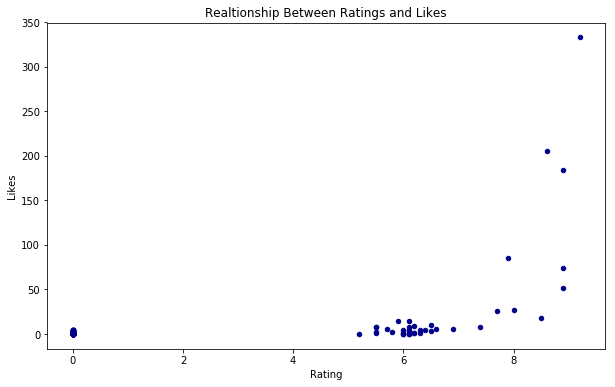

In [128]:
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt

foodplaces_pizza_plt = foodplaces_pizza

# clean up the dataset to remove unnecessary columns (eg. REG) 
#foodplaces_pizza_plt.drop(['Name', 'ID', 'Type', 'Latitude', 'Longitude'], axis=1, inplace=True)

# for sake of consistency, let's also make all column labels of type string
foodplaces_pizza_plt.columns = list(map(str, foodplaces_pizza_plt.columns))

# set the country name as index - useful for quickly looking up countries using .loc method
#foodplaces_pizza_plt.set_index('Postcode', inplace=True)

foodplaces_pizza_plt.plot(kind='scatter', x='Rating', y='Likes', figsize=(10, 6), color='darkblue')

plt.title('Realtionship Between Ratings and Likes')
plt.xlabel('Rating')
plt.ylabel('Likes')

Text(0, 0.5, 'Rating')

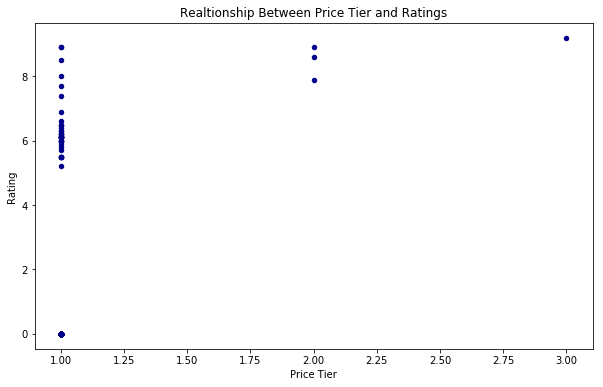

In [129]:
foodplaces_pizza_plt.plot(kind='scatter', x='Price', y='Rating', figsize=(10, 6), color='darkblue')

plt.title('Realtionship Between Price Tier and Ratings')
plt.xlabel('Price Tier')
plt.ylabel('Rating')

In [134]:
foodplaces_pizza_plt = pd.read_csv('foodplaces')
foodplaces_pizza_plt.head()

,Unnamed: 0,Postcode,Name,ID,Type,Price,Rating,Likes,Latitude,Longitude
0,6,M1E,Swiss Chalet Rotisserie & Grill,4b6074e3f964a5200fe729e3,Pizza,1,6.5,10,43.767697,-79.189914
1,11,M1E,A1 Pizza,58cb03605a5869277d557db0,Pizza,1,0.0,0,43.762176,-79.183076
2,33,M1J,Primo Pizza,4c97ad9238dd8cfa61bfe562,Pizza,1,0.0,0,43.744759,-79.244751
3,52,M1N,Enrico's Pizza,58e385043f5a5c5d21c557d1,Pizza,1,0.0,0,43.692887,-79.262425
4,55,M1N,Enricos Pizza,4bdf3db10ee3a5930a7533b0,Pizza,1,0.0,1,43.694003,-79.262701


# Cluster Pizza Restaurants by Similarity Base on Ratings and Likes

In [135]:
import numpy as np

foodplaces_pizza_xy = np.column_stack((foodplaces_pizza_plt['Rating'], foodplaces_pizza_plt['Likes']))

In [136]:
# import k-means from clustering stage
from sklearn.cluster import KMeans
from sklearn import preprocessing

# set number of clusters
kclusters = 10

foodplaces_pizza_xy = preprocessing.StandardScaler().fit(foodplaces_pizza_xy).transform(foodplaces_pizza_xy.astype(float))

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(foodplaces_pizza_xy)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([7, 0, 0, 0, 0, 1, 0, 8, 0, 1], dtype=int32)

## Add Cluster Labels

In [137]:
# add clustering labels

foodplaces_pizza.insert(0, 'Cluster Labels', kmeans.labels_)

foodplaces_pizza.head()

,Cluster Labels,Postcode,Name,ID,Type,Price,Rating,Likes,Latitude,Longitude
6,7,M1E,Swiss Chalet Rotisserie & Grill,4b6074e3f964a5200fe729e3,Pizza,1,6.5,10,43.767697,-79.189914
11,0,M1E,A1 Pizza,58cb03605a5869277d557db0,Pizza,1,0.0,0,43.762176,-79.183076
33,0,M1J,Primo Pizza,4c97ad9238dd8cfa61bfe562,Pizza,1,0.0,0,43.744759,-79.244751
52,0,M1N,Enrico's Pizza,58e385043f5a5c5d21c557d1,Pizza,1,0.0,0,43.692887,-79.262425
55,0,M1N,Enricos Pizza,4bdf3db10ee3a5930a7533b0,Pizza,1,0.0,1,43.694003,-79.262701


## Visualize the resulting clusters

In [138]:
# create map

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []


for i in range(0, len(foodplaces_pizza)):
    cluster = foodplaces_pizza.iloc[i, 0]
    lat = foodplaces_pizza.iloc[i, 8]
    lng = foodplaces_pizza.iloc[i, 9]
    price = foodplaces_pizza.iloc[i, 5]
    rating = foodplaces_pizza.iloc[i, 6]
    likes = foodplaces_pizza.iloc[i, 7]
    label = folium.Popup('Rating ' + str(rating) + ',' + ' Likes ' + str(likes), parse_html=True)
    
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
    
map_clusters